Import the necessary libraries and create an outputs folder to store train results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from data import FlowersDataset, split_dataset
from network import Net
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import random
from torchvision.utils import make_grid 
from sklearn.metrics import confusion_matrix

import pandas as pd
import seaborn as sn
import cv2
from PIL import Image


from torchvision import  transforms
import torchvision.transforms.functional as F

if not os.path.exists('./outputs'):
    os.mkdir('./outputs')
    

print('Imports OK')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Imports OK


Set global parameters to get prepared for training. Note that USE_CUDA parameter is used to decide which device is going to use for training. If you have a GPU and cuda is available to run the model in your GPU, its better to set this parameter to True. In this tutorial's built in framework we are only able to use CPU so we set this parameter to False

In [2]:
""" Set Global Parameters """

USE_CUDA = False

DATASET_PATH = './data_flowers/'

BATCH_SIZE = 16 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 15 # Number of times we will go through all the training images. 

LEARNING_RATE = 0.01 # Initial learning rate
MOMENTUM = 0.9 # Momentum for the gradient descent (SGD with momentum will be used)
WEIGHT_DECAY = 0.001 # L2 Regularization factor to reduce overfitting

nb_classes = 3

#reproducibility
np.random.seed(0)
random.seed(0)  
torch.manual_seed(0) 

if USE_CUDA:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #check again if cuda is really available
else:
    device = torch.device("cpu")

print('Parameters OK')
print("using :", device)


Parameters OK
using : cpu


In [3]:
""" Create Neural Network """

model = Net(nb_classes) 
    
# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
scheduler = ExponentialLR(optimizer, gamma=0.98, verbose=True)

model.train()
model.to(device) 

print(model)

print('Network OK')

Adjusting learning rate of group 0 to 1.0000e-02.
Net(
  (convolutions): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=12544, out_features=1000, b

We will use FlowersDataset class that we examined in the previous lecture, but to be able to import it we had to create a data.py module since .ipynb files can't be used as modules to import. After that, data preparation steps are similar with previous lecture.

In [4]:
""" Prepare Data """

generator=torch.Generator().manual_seed(42)

train_list, val_list, test_list, class_idx = split_dataset(data_path = "./data_flowers/")

train_transforms=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240,240)),
    transforms.ToTensor()
])    

val_transforms=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240,240)),
    transforms.ToTensor()
])  

train_dataset = FlowersDataset(train_list, class_idx, train_transforms)
val_dataset = FlowersDataset(val_list, class_idx, val_transforms)
test_dataset = FlowersDataset(test_list, class_idx, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print('Dataloaders OK')

Dataset includes 184  images
 110  of them assigned into train 36  of them assigned into in test 38  of them assigned into validation sub dataset
Dataloaders OK


Creating run_epoch function to run 1 epoch. <br>

For this purpose, we load the data by batchs using our dataloader and tqdm built-in function, we will send these images directly to the model <b> outputs = model(imgs.float()) </b> and calculate the loss <b> loss = criterion(outputs, labels) </b>. We put gradients to zero, before calculating the current gradients to be sure they dont accumulate <b> optimizer.zero_grad() </b> finally we use loss to calculate the gradients and apply backpropagation <b> loss.backward() </b>. Using <b> optimizer.step() </b> function we update our optimizer (SGD + momentum) to prepare it for the next batch. (Remember that with momentum we keep the old gradients with their weighted average) 

As the next step, we extract the predicted class <b> _, predicted = torch.max(outputs.data, 1) </b> and check if its true or not. According to this, we calculate the train accuracy at the end of the epoch. 

As you may know, accuracy in image classification is simply (correct predictions / total predictions)

In [5]:
def run_epoch(net, optimizer, dataloader, criterion, train=True):
    epoch_total_loss = 0
    epoch_total_samples = 0
    epoch_total_correct = 0


    for batch in tqdm(dataloader):
        imgs, labels = batch[0].to(device), batch[1].to(device)
   
        outputs = model(imgs.float())
        loss = criterion(outputs, labels)
           
        """ 
            Note that this function will be used to calculate validation loss & accuracy also.
            But the gradients should be updated only with train dataset. So we use if train: statement
        """
        if train: 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        
        with torch.no_grad():
            epoch_total_samples += labels.size(0)
            epoch_total_loss += loss.item()
            epoch_total_correct += (predicted == labels).sum().item()

    return epoch_total_loss / epoch_total_samples, epoch_total_correct / epoch_total_samples

Time to train!



Running epoch 1 of 15...



100%|██████████| 9/9 [00:00<00:00, 40.28it/s]



Epoch 1 validation results: Loss=0.28385257224241894 | Accuracy=0.3333333333333333

Adjusting learning rate of group 0 to 9.8000e-03.


Running epoch 2 of 15...



100%|██████████| 9/9 [00:00<00:00, 50.28it/s]



Epoch 2 validation results: Loss=0.2882990522517098 | Accuracy=0.3055555555555556

Adjusting learning rate of group 0 to 9.6040e-03.


Running epoch 3 of 15...



100%|██████████| 9/9 [00:00<00:00, 50.14it/s]



Epoch 3 validation results: Loss=0.2812376452816857 | Accuracy=0.4166666666666667

Adjusting learning rate of group 0 to 9.4119e-03.


Running epoch 4 of 15...



100%|██████████| 9/9 [00:00<00:00, 46.40it/s]



Epoch 4 validation results: Loss=0.26351459986633724 | Accuracy=0.4166666666666667

Adjusting learning rate of group 0 to 9.2237e-03.


Running epoch 5 of 15...



100%|██████████| 9/9 [00:00<00:00, 49.06it/s]



Epoch 5 validation results: Loss=0.29035986628797317 | Accuracy=0.3055555555555556

Adjusting learning rate of group 0 to 9.0392e-03.


Running epoch 6 of 15...



100%|██████████| 9/9 [00:00<00:00, 49.46it/s]



Epoch 6 validation results: Loss=0.2336872418721517 | Accuracy=0.6111111111111112

Adjusting learning rate of group 0 to 8.8584e-03.


Running epoch 7 of 15...



100%|██████████| 9/9 [00:00<00:00, 51.22it/s]



Epoch 7 validation results: Loss=0.2503812594546212 | Accuracy=0.5277777777777778

Adjusting learning rate of group 0 to 8.6813e-03.


Running epoch 8 of 15...



100%|██████████| 9/9 [00:00<00:00, 47.50it/s]



Epoch 8 validation results: Loss=0.2727937234772576 | Accuracy=0.4444444444444444

Adjusting learning rate of group 0 to 8.5076e-03.


Running epoch 9 of 15...



100%|██████████| 9/9 [00:00<00:00, 46.61it/s]



Epoch 9 validation results: Loss=0.27688077423307633 | Accuracy=0.4166666666666667

Adjusting learning rate of group 0 to 8.3375e-03.


Running epoch 10 of 15...



100%|██████████| 9/9 [00:00<00:00, 52.34it/s]



Epoch 10 validation results: Loss=0.2661828051010768 | Accuracy=0.5

Adjusting learning rate of group 0 to 8.1707e-03.


Running epoch 11 of 15...



100%|██████████| 9/9 [00:00<00:00, 45.58it/s]



Epoch 11 validation results: Loss=0.28077757855256397 | Accuracy=0.3888888888888889

Adjusting learning rate of group 0 to 8.0073e-03.


Running epoch 12 of 15...



100%|██████████| 9/9 [00:00<00:00, 51.24it/s]



Epoch 12 validation results: Loss=0.2804033938381407 | Accuracy=0.4166666666666667

Adjusting learning rate of group 0 to 7.8472e-03.


Running epoch 13 of 15...



100%|██████████| 9/9 [00:00<00:00, 48.37it/s]



Epoch 13 validation results: Loss=0.27879340946674347 | Accuracy=0.4166666666666667

Adjusting learning rate of group 0 to 7.6902e-03.


Running epoch 14 of 15...



100%|██████████| 9/9 [00:00<00:00, 49.81it/s]



Epoch 14 validation results: Loss=0.27078329026699066 | Accuracy=0.4444444444444444

Adjusting learning rate of group 0 to 7.5364e-03.


Running epoch 15 of 15...



100%|██████████| 9/9 [00:00<00:00, 46.24it/s]



Epoch 15 validation results: Loss=0.2596956325901879 | Accuracy=0.4722222222222222

Adjusting learning rate of group 0 to 7.3857e-03.
model saved into './outputs/model.pt'
Final train loss: 0.18624434742060575
Final val loss: 0.2596956325901879
Final train accuracy: 0.8090909090909091
Final val accuracy: 0.4722222222222222


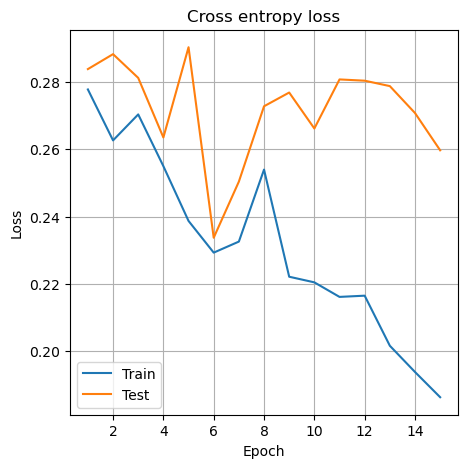

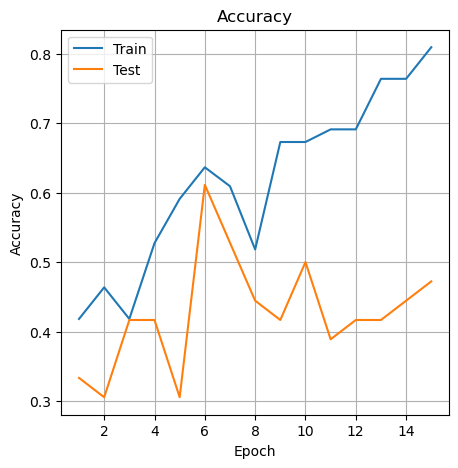

In [6]:
""" Train """

trained_model = './outputs/model.pt' # final model will be saved 

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
epochs = []
    
for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------

    loss, accuracy = run_epoch(model, optimizer, train_loader, criterion, train=True)
    train_loss.append(loss)
    train_accuracy.append(accuracy)

    #-------------------------Validation--------------------------
    # Set network train/test mode to 'test' in the next line

    with torch.no_grad():
        loss_val, accuracy_val = run_epoch(model, optimizer, test_loader, criterion, train=False)
    val_loss.append(loss_val)
    val_accuracy.append(accuracy_val)
    print(f'\nEpoch {epoch} validation results: Loss={loss_val} | Accuracy={accuracy_val}\n')

    scheduler.step()

    #  print("current learning rate:", optimizer.param_groups[0]['lr'])

    # Plot and save
    plt.figure(figsize=(5, 5), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss.pdf')

    plt.figure(figsize=(5, 5), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, val_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy.pdf')


torch.save(model.state_dict(), './outputs/model.pt')
print("model saved into './outputs/model.pt'")

del model

print(f'Final train loss: {train_loss[-1]}')
print(f'Final val loss: {val_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final val accuracy: {val_accuracy[-1]}')

Time to test!

Now that we have our trained model, we will create again a model object with our network structure and
load the trained weights from our model.pt file.

After this its pretty similar to load the data and pass the images trough the network to calculate test accuracy. 
To make it more similar to the inference, we don't use run_epoch function. We only pass the image through the model and check the result.

In [7]:
 """ Test """
epoch_total_correct = 0
epoch_total_samples = 0
test_accuracy = 0

model = Net(len(class_idx)) 
model.load_state_dict(torch.load('./outputs/model.pt'))
model.eval()
model.to(device) 

print(model)


BATCH_SIZE = 1

y_pred = []
y_true = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(imgs.float())
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        with torch.no_grad():
            epoch_total_samples += labels.size(0)
            epoch_total_correct += (predicted == labels).sum().item()


    test_accuracy = epoch_total_correct / epoch_total_samples

print(f'Final test accuracy: {test_accuracy}')

Net(
  (convolutions): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=12544, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Lin

100%|██████████| 9/9 [00:00<00:00, 50.42it/s]

Final test accuracy: 0.5


### Confusion matrix

A confusion matrix is an organized way of mapping the predictions to the original classes to which the data belong. By creating a confusion matrix, we can visualize the model performance better to see which class the model predicts correct, and if it doesn't, which wrong class replace the correct one's place. Apart from that, we can also see the current class takes which class's place. <br>

To understand confusion matrix, let's review the related terms by examining daisy class: <br>

<b>True Positive:</b> The prediction and correct class matches (The image belongs to daisy class, and the model predicted this image as daisy) <br>
<b>True Negative:</b> The class didn't take the place of any other correct class. (The image belongs to the rose class, and the model didn't make any mistake by saying its daisy) <br>
<b>False Positive:</b> The prediction is wrong! It was a rose but the model predicted as daisy <br>
<b>False Negative:</b> The prediction is wrong! It was a daisy but the model assigned any other class. <br>

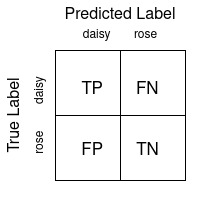

We can create a confusion matrix using sklearn librarie's confusion_matrix function, to visualize this matrix (to convert it from a simple 2D matrix to colorful plot), we will use panda library. Note that in sklearn's confusion matrix the true labels are the rows and predictions are the columns as the example explaining the logic of confusion matrix above. This can be changed depending on the confusion matrix function you use, but its enough that you know the logic!

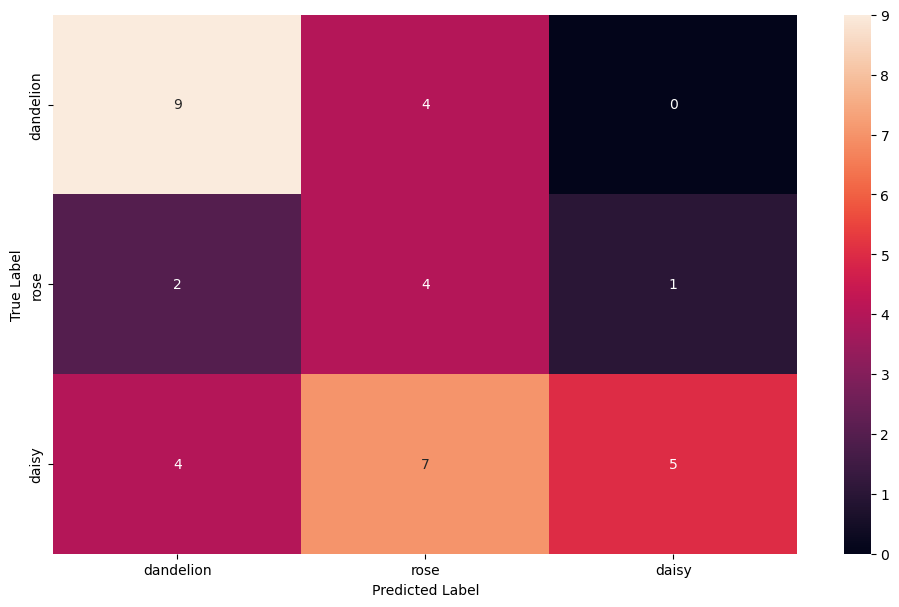

In [8]:
cf_matrix = confusion_matrix(y_true, y_pred)
panda_matrix = pd.DataFrame(cf_matrix, index = [i for i in class_idx.keys()], columns = [i for i in class_idx.keys()])
plt.figure(figsize = (12,7))
sn.heatmap(panda_matrix, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./outputs/confusion_matrix.png')

### Final Words

You should be aware that our results are not fascinating actually. We see that the train accuracy and loss seem to improve but validation loss and accuracy can't catch it. In the next section, you will learn how to improve your training using fine tuning methods!